In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/summary.csv')
dahlia_accepted = pd.read_csv('data/accepted.txt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 14 columns):
status         4608 non-null object
est_avg_lat    4608 non-null int64
est_lut        4608 non-null int64
bench          4608 non-null object
unroll         4608 non-null int64
est_bram       4608 non-null int64
bank2          4608 non-null int64
est_min_lat    4608 non-null int64
est_dsp        4608 non-null int64
resource1      4608 non-null object
resource2      4608 non-null object
est_max_lat    4608 non-null int64
est_ff         4608 non-null int64
bank1          4608 non-null int64
dtypes: int64(10), object(4)
memory usage: 504.1+ KB


In [3]:
# Make sure estimated latencies are consistent
for idx in range(len(df)):
    assert df.est_min_lat[idx] == df.est_max_lat[idx] and df.est_max_lat[idx] == df.est_avg_lat[idx]

# Cleanup bench names
df.bench = df.apply(lambda row: row.bench.replace('test:dot-product-', ''), axis=1)
dahlia_accepted = dahlia_accepted.apply(lambda row: row.bench.replace('./dahlia-dot-product-', ''), axis=1)

In [4]:
dahlia_points = df[df["bench"].isin(dahlia_accepted.to_numpy())]

In [5]:
# Set of scatter plots to draw
resources = [ 'est_' + key for key in [ 'ff', 'dsp', 'bram', 'lut' ]]
lat_plots = [ ('est_avg_lat', key) for key in resources ]
lut_plots = [ ('est_lut', key) for key in resources]

In [6]:
# Calculate pareto points
# From: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
        if is_efficient[i]:
            print(c)
    return is_efficient

opts = find_pareto(df[resources + ['est_avg_lat']].to_numpy())
opt_idxs = np.where(opts == True)

[ 2715    12    20  2562 12319]
[5796   48   20 3734 9247]
[3751   24   20 2941 9589]
[5796   48   20 3754 8906]
[6362   48   36 4921 8567]
[ 2608    12    20  2610 30058]
[8680   80   20 4740 8839]
[5327   50   24 3614 8637]
[ 2715    12    20  2564 10954]
[3034   12   20 2825 9590]
[9853   96   20 5162 8736]
[5249   40   20 4287 9043]
[6024   60   28 3879 8569]
[ 2692    12    20  2692 12319]
[4002   30   28 3104 8910]
[ 2692    12    20  2703 10954]
[9860   96   36 5284 8565]
[5060   40   20 3443 9452]
[5685   48   28 4359 8906]


Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Resources & Latency)')

<Figure size 432x288 with 0 Axes>

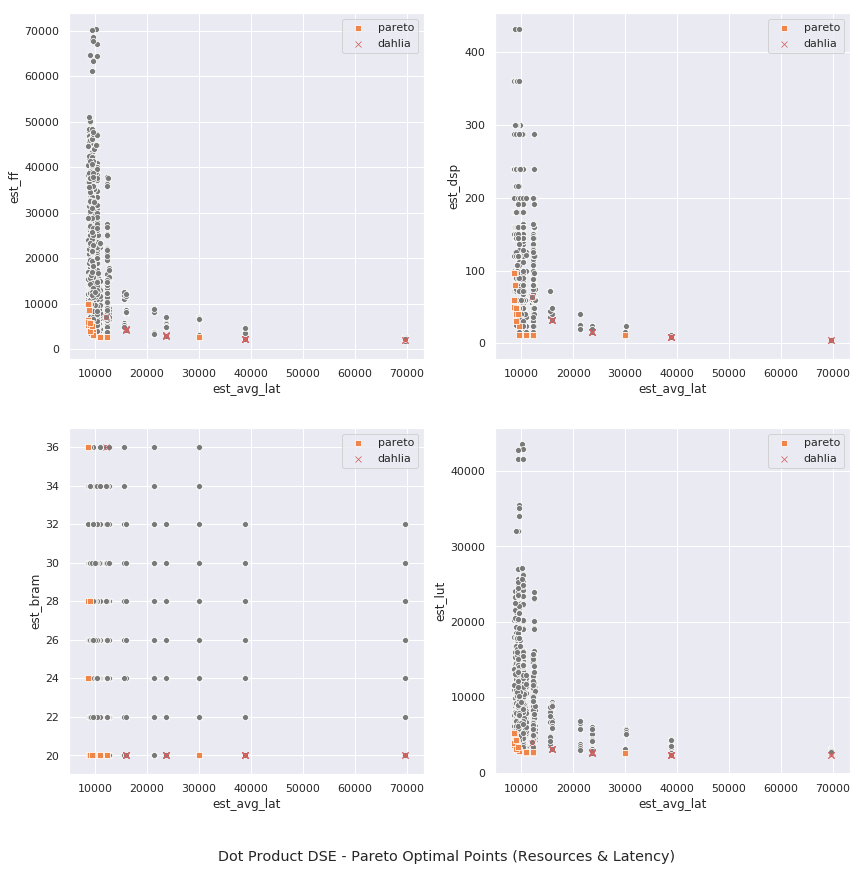

In [7]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lat_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
pal = sns.color_palette('muted', 8)
# Colors
pareto = pal[1]
dahlia = pal[3]

for idx, (x_key, y_key) in enumerate(lat_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=df.loc[opt_idxs], ax=ax, color=pareto, marker='s', label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='x', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Resources & Latency)', y = 0.05)

In [8]:
fig.savefig('pareto-latency.png', dpi=300)

Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Resources & Latency)')

<Figure size 432x288 with 0 Axes>

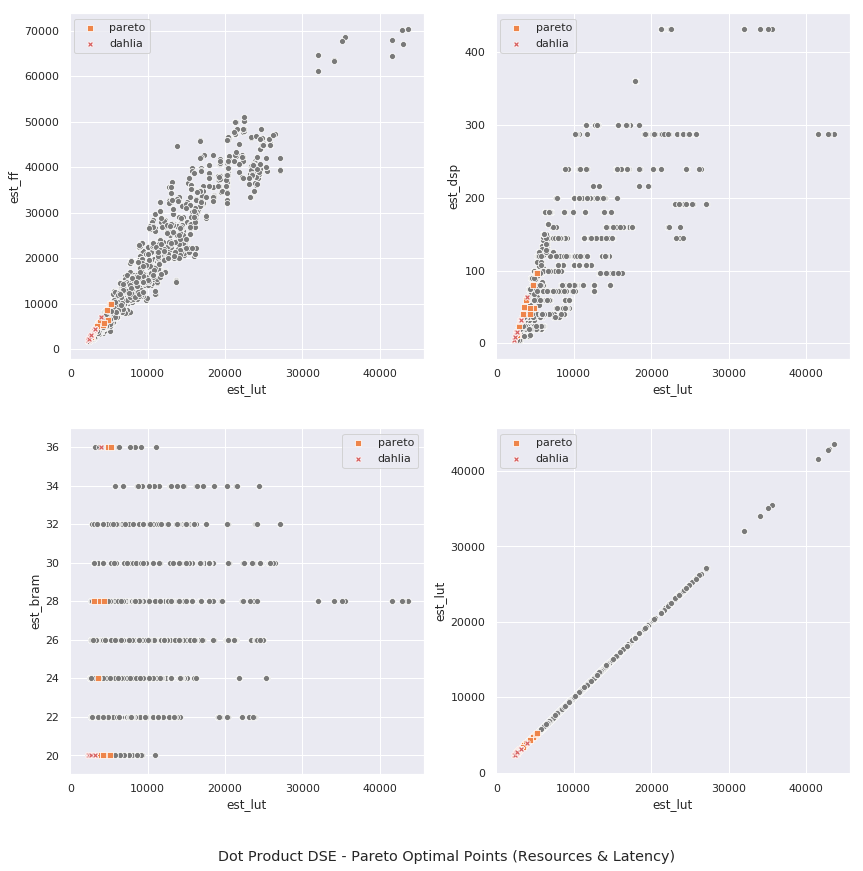

In [9]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lut_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))

for idx, (x_key, y_key) in enumerate(lut_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=df.loc[opt_idxs], ax=ax, color=pareto, marker='s', label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='X', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Resources & Latency)', y = 0.05)

In [10]:
fig.savefig('pareto-lut.png', dpi=300)

In [11]:
# Calculate pareto optimal points w/o latency as an optimization function
# Since pareto requires strict >, we have to remove points that have the [resources] counts
no_dup = df.drop_duplicates(subset=resources)
opts = find_pareto(no_dup[resources].to_numpy())
optimal_points = no_dup.iloc[np.where(opts == True)]
count = 0
idxs = []

# Recover the points that have the same [resource counts]
for idx in range(len(df)):
    flag = False
    # print(no_dup.loc[idx][resources])
    for c_idx in range(len(optimal_points)):
        x = df.iloc[idx][resources].equals(optimal_points.iloc[c_idx][resources])
        # print("{} \t {} \t {}".format(no_dup.iloc[idx].bench, optimal_points.iloc[c_idx].bench, x))
        flag = flag or x
    if flag:
        count += 1
        idxs.append(df.iloc[idx].bench)
        print(df.iloc[idx].bench)
print(count)

[1869    4   20 2277]
[1932    4   20 2268]
0-1-0-1-1
0-1-0-1-0
0-0-0-1-0
0-1-0-0-0
0-0-0-1-1
0-1-0-0-1
0-0-0-0-1
0-0-0-0-0
8


Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Only Resources)')

<Figure size 432x288 with 0 Axes>

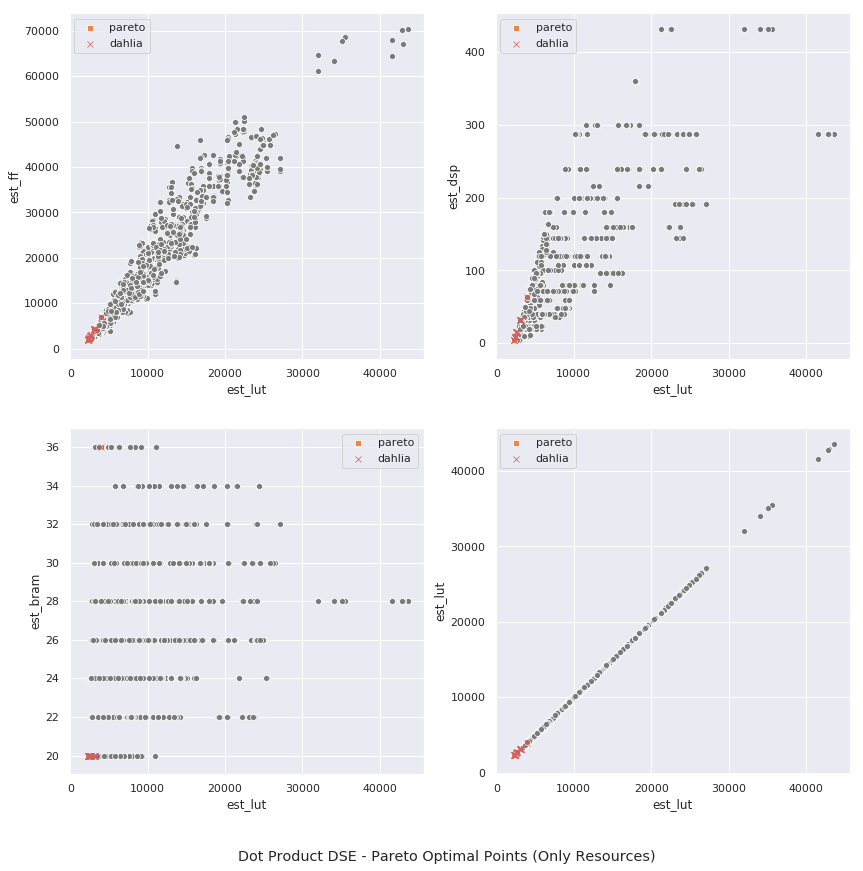

In [12]:
# pareto optimal points for just [resources]
resource_optimal_df = df[df.bench.isin(idxs)]
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lut_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
pal = sns.color_palette('muted', 8)

for idx, (x_key, y_key) in enumerate(lut_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=resource_optimal_df, ax=ax, marker='s', color=pareto, label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='x', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Only Resources)', y = 0.05)

In [13]:
fig.savefig('pareto-resource-lut.png', dpi=300)

In [18]:
dahlia_points.sort_values(by=['est_avg_lat'])[:10]

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
635,ok,12044,3921,7-7-11-1-1,16,36,8,12044,64,RAM_T2P_BRAM,RAM_T2P_BRAM,12044,7047,8
4078,ok,15884,3178,7-7-6-0-1,8,20,8,15884,32,RAM_1P_BRAM,RAM_T2P_BRAM,15884,4362,8
85,ok,15884,3096,7-3-6-1-1,8,20,4,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4312,8
3805,ok,15884,3178,7-7-6-1-0,8,20,8,15884,32,RAM_T2P_BRAM,RAM_1P_BRAM,15884,4362,8
3559,ok,15884,3178,7-7-6-1-1,8,20,8,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4362,8
672,ok,15884,3064,3-7-6-1-1,8,20,8,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4237,4
3527,ok,15884,3064,3-7-6-1-0,8,20,8,15884,32,RAM_T2P_BRAM,RAM_1P_BRAM,15884,4237,4
3512,ok,15884,3096,7-3-6-0-1,8,20,4,15884,32,RAM_1P_BRAM,RAM_T2P_BRAM,15884,4312,8
2771,ok,15884,3068,3-3-6-1-1,8,20,4,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4392,4
2321,ok,15884,3178,7-7-6-0-0,8,20,8,15884,32,RAM_1P_BRAM,RAM_1P_BRAM,15884,4362,8


In [17]:
df.iloc[opt_idxs].sort_values(by=['est_avg_lat'])[:10]

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
4182,ok,8565,5284,7-7-14-1-1,24,36,8,8565,96,RAM_T2P_BRAM,RAM_T2P_BRAM,8565,9860,8
1314,ok,8567,4921,7-7-9-1-1,12,36,8,8567,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8567,6362,8
3772,ok,8569,3879,5-5-9-1-1,12,28,6,8569,60,RAM_T2P_BRAM,RAM_T2P_BRAM,8569,6024,6
3002,ok,8637,3614,4-4-8-1-1,10,24,5,8637,50,RAM_T2P_BRAM,RAM_T2P_BRAM,8637,5327,5
3459,ok,8736,5162,3-7-14-1-0,24,20,8,8736,96,RAM_T2P_BRAM,RAM_1P_BRAM,8736,9853,4
1581,ok,8839,4740,3-3-13-1-1,20,20,4,8839,80,RAM_T2P_BRAM,RAM_T2P_BRAM,8839,8680,4
4311,ok,8906,4359,3-7-9-1-1,12,28,8,8906,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8906,5685,4
857,ok,8906,3754,3-3-9-1-1,12,20,4,8906,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8906,5796,4
3893,ok,8910,3104,2-2-5-1-1,6,28,3,8910,30,RAM_T2P_BRAM,RAM_T2P_BRAM,8910,4002,3
3479,ok,9043,4287,3-3-8-1-1,10,20,4,9043,40,RAM_T2P_BRAM,RAM_T2P_BRAM,9043,5249,4


In [16]:
resource_optimal_df.sort_values(by='est_avg_lat')

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
1046,ok,69644,2277,0-1-0-1-1,1,20,2,69644,4,RAM_T2P_BRAM,RAM_T2P_BRAM,69644,1869,1
1523,ok,69644,2277,0-1-0-1-0,1,20,2,69644,4,RAM_T2P_BRAM,RAM_1P_BRAM,69644,1869,1
1717,ok,69644,2268,0-0-0-1-0,1,20,1,69644,4,RAM_T2P_BRAM,RAM_1P_BRAM,69644,1932,1
1809,ok,69644,2277,0-1-0-0-0,1,20,2,69644,4,RAM_1P_BRAM,RAM_1P_BRAM,69644,1869,1
2373,ok,69644,2268,0-0-0-1-1,1,20,1,69644,4,RAM_T2P_BRAM,RAM_T2P_BRAM,69644,1932,1
2599,ok,69644,2277,0-1-0-0-1,1,20,2,69644,4,RAM_1P_BRAM,RAM_T2P_BRAM,69644,1869,1
3405,ok,69644,2268,0-0-0-0-1,1,20,1,69644,4,RAM_1P_BRAM,RAM_T2P_BRAM,69644,1932,1
3958,ok,69644,2268,0-0-0-0-0,1,20,1,69644,4,RAM_1P_BRAM,RAM_1P_BRAM,69644,1932,1
